# Manual implementation of the Mersenne twister PseudoRandom Number Generator (PRNG)
This small notebook is a short experiment, to see if I can implement an the Manual implementation of the [Mersenne twister](https://en.wikipedia.org/wiki/Mersenne_twister) PseudoRandom Number Generator ([PRNG](https://en.wikipedia.org/wiki/Pseudo-random_number_generator)).

- *Reference*: [Wikipedia](https://en.wikipedia.org/wiki/Mersenne_twister), and this book: ["Simulation and the Monte-Carlo method", by R.Y.Rubinstein & D.P.Kroese](http://www.wiley.com/WileyCDA/WileyTitle/productCd-1118632168.html) ([Rubinstein & Kroese, 2017]), chapter 2 pages 52-53.
- *Date*: 11 March 2017.
- *Author*: [Lilian Besson](https://GitHub.com/Naereen/notebooks).
- *License*: [MIT Licensed](https://lbesson.mit-license.org/).

----

## Common API for the PRNG defined here
First, I want to define a simple object-oriented API, in order to write all the examples of PNRG with the same interface.

In [91]:
import numpy as np

In [118]:
class PRNG(object):
    """Base class for any Pseudo-Random Number Generator."""
    def __init__(self, X0=0):
        """Create a new PRNG with seed X0."""
        self.X0 = X0
        self.X = X0
        self.t = 0
        self.max = 0
    
    def __iter__(self):
        return self
    
    def seed(self, X0=None):
        """Reinitialize the current value with X0, or self.X0.
        
        - Tip: Manually set the seed if you need reproducibility in your results.
        """
        self.t = 0
        self.X = self.X0 if X0 is None else X0
    
    def __next__(self):
        """Produce a next value and return it."""
        # This default PRNG does not produce random numbers!
        self.t += 1
        return self.X
    
    def randint(self, *args, **kwargs):
        """Return an integer number in [| 0, self.max - 1 |] from the PRNG."""
        return self.__next__()

    def int_samples(self, shape=(1,)):
        """Get a numpy array, filled with integer samples from the PRNG, of shape = shape."""
        # return [ self.randint() for _ in range(size) ]
        return np.fromfunction(np.vectorize(self.randint), shape=shape, dtype=int)

    def rand(self, *args, **kwargs):
        """Return a float number in [0, 1) from the PRNG."""
        return self.randint() / float(self.max)

    def float_samples(self, shape=(1,)):
        """Get a numpy array, filled with float samples from the PRNG, of shape = shape."""
        # return [ self.rand() for _ in range(size) ]
        return np.fromfunction(np.vectorize(self.rand), shape=shape, dtype=int)

----
## First example: a simple linear congruential generator
Let me start by implementing a simple linear congruential generator, with three parameters $m$, $a$, $c$, defined like this :

- Start from $X_0$,
- And then follow the recurrence equation: $$ X_{t+1} = (a X_t + c) \mod m. $$

This algorithm produces a sequence $(X_t)_{t\in\mathbb{N}} \in \mathbb{N}^{\mathbb{N}}$.

In [119]:
class LinearCongruentialGenerator(PRNG):
    """A simple linear congruential Pseudo-Random Number Generator."""
    def __init__(self, m, a, c, X0=0):
        """Create a new PRNG with seed X0."""
        super(LinearCongruentialGenerator, self).__init__(X0=X0)
        self.m = m
        self.a = a
        self.c = c
        self.max = m
    
    def __next__(self):
        """Produce a next value and return it, following the recurrence equation: X_{t+1} = (a X_t + c) mod m."""
        self.t += 1
        x = self.X
        self.X = (self.a * self.X + self.c) % self.m
        return x

The values recommended by the authors, Lewis, Goodman and Miller, are the following:

In [120]:
m = 1 << 31 - 1  # 1 << 31 = 2**31
a = 7 ** 4
c = 0

The seed is important. If $X_0 = 0$, this first example PRNG will only produce $X_t = 0, \forall t$.

In [121]:
FirstExample = LinearCongruentialGenerator(m=m, a=a, c=c)

In [122]:
def test(example, nb=3):
    for t, x in enumerate(example):
        print("{:>3}th value for {.__class__.__name__} is X_t = {:>10}".format(t, example, x))
        if t >= nb - 1:
            break

In [123]:
test(FirstExample)

  0th value for LinearCongruentialGenerator is X_t =          0
  1th value for LinearCongruentialGenerator is X_t =          0
  2th value for LinearCongruentialGenerator is X_t =          0


But with any positive seed, the sequence will appear random.

In [124]:
SecondExample = LinearCongruentialGenerator(m=m, a=a, c=c, X0=12011993)

In [125]:
test(SecondExample)

  0th value for LinearCongruentialGenerator is X_t =   12011993
  1th value for LinearCongruentialGenerator is X_t =  923507769
  2th value for LinearCongruentialGenerator is X_t =   65286809


The sequence is completely determined by the seed $X_0$:

In [126]:
SecondExample.seed(12011993)
test(SecondExample)

  0th value for LinearCongruentialGenerator is X_t =   12011993
  1th value for LinearCongruentialGenerator is X_t =  923507769
  2th value for LinearCongruentialGenerator is X_t =   65286809


> Note: I prefer to use this custom class to define iterators, instead of a simple generator (with `yield` keyword) as I want them to have a `.seed(X0)` method.

----
## Checking and plotting the result?
First, we can generate a matrix of samples, as random floats in $[0, 1)$, and check that the mean is about $1/2$:

In [137]:
image = SecondExample.float_samples((400, 400))

In [138]:
np.mean(image), np.var(image)

(0.50064966539293532, 0.083338618333195807)

We can also plot this image as a grayscaled image, in order to visualize this "randomness" we just created.

In [161]:
import matplotlib.pyplot as plt

def seeimage(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

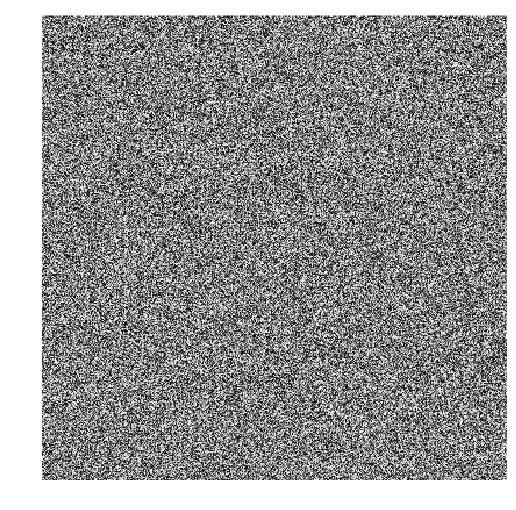

In [162]:
seeimage(image)

It looks good already! We can't see any recurrence, but we see a regularity, with small squares.

----
## A second example of PRNG